# **Data pre-processing**

Approach:

1. Download and Extract data into desired directory
2. Create pd.DataFrame of core metadata for each image and path to its directory location
3. Apply train, validation, test splits
4. Convert pd.DataFrames to tf.Datasets, preprocessing images and labels in the process (ie: normalizing image pixels, one hot encoding labels)
5. Use tf.keras.layers to define image augmentations
6. Compile model with chosen augmentations
7. Train with hold-out validation
8. Test

# Libraries

In [ ]:
# Libraries
import matplotlib.pyplot as plt
import plotly.express as px
import random
import os
import tarfile
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.utils import load_img, img_to_array
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from sklearn.model_selection import train_test_split
from urllib.request import urlretrieve
from pathlib import Path
import pandas as pd
from typing import List, Dict, Tuple

# Constants

In [ ]:
# Constants
DATA_URL = "https://data.caltech.edu/records/65de6-vp158/files/CUB_200_2011.tgz?download=1"
DATA_DIR = Path("/content/sample_data")
ARCHIVE_PATH = DATA_DIR / "CUB_200_2011.tgz"
EXTRACT_DIR = DATA_DIR / "CUB_200_2011"

# Functions

In [ ]:
# Download data function
def download_dataset(url: str = DATA_URL, save_path: Path = ARCHIVE_PATH) -> Path:
    """Download dataset archive if not already present."""
    save_path.parent.mkdir(parents=True, exist_ok=True)
    if not save_path.exists():
        print(f"Downloading dataset from {url}...")
        urlretrieve(url, save_path)
        print("Download complete.")
    else:
        print("Archive already exists.")
    return save_path

In [ ]:
# Extract data function
def extract_dataset(archive_path: Path = ARCHIVE_PATH, extract_to: Path = EXTRACT_DIR) -> Path:
    """Extract dataset from tar archive."""
    if not extract_to.exists():
        print(f"Extracting {archive_path}...")
        with tarfile.open(archive_path, "r:gz") as tar:
            tar.extractall(path=extract_to.parent)
        print("Extraction complete.")
    else:
        print("Dataset already extracted.")
    return extract_to

In [ ]:
# Fetch random sample images
def fetch_sample_images(image_dir: Path, n: int = 5) -> list[Path]:
    """
    Randomly select one species folder and return a list of 'n' sample image paths.

    Args:
        image_dir (Path): Directory containing all species subfolders.
        n (int): Number of images to sample from the selected species.

    Returns:
        list[Path]: List of image file paths.
    """
    # Create a list of species folder paths with list comprehension
    species_folders = sorted([p for p in image_dir.iterdir() if p.is_dir()])
    # .iterdir() yields all immediate children of a directory as Path objects
    # .is_dir() yields True if entry is a directory, False if file
    if not species_folders:
        raise ValueError(f"No species folders found in {image_dir}.")

    # Choose one random species folder
    sample_species = random.choice(species_folders)
    print(f"Randomly selected species: {sample_species.name}")

    # Create a list of up to 'n' image paths
    image_paths = list(sample_species.glob("*.jpg"))[:n]  # first n images
    # .glob() yields all files that match the "*.jpg" pattern as Path objects
    if not image_paths:
        raise ValueError(f"No images found in {sample_species}.")

    return image_paths


In [ ]:
# Plot given images
def plot_sample_images(images_paths: list[Path], target_size: tuple[int, int] | None = None) -> None:
    """
    Plots a list of image paths in a single row.

    Args:
        image_paths (list[Path]): List of paths to images.
    """
    if not image_paths:
        raise ValueError("No image paths provided to plot.")

    plt.figure(figsize=(15, 6))
    for i, img_path in enumerate(image_paths):
        img = load_img(img_path, target_size=target_size)
        plt.subplot(1, len(image_paths), i + 1)
        plt.imshow(img)
        plt.title(img_path.parent.name, fontsize=10)
        plt.axis("off")
    plt.tight_layout()
    plt.show()

In [ ]:
# Create official test split functions

# Fetch train-test split
def fetch_split(dataset_dir: Path) -> pd.DataFrame:
    """
    Fetch the CUB_200_2011 train-test split file 'train_test_split.txt' and return as df.

    Args:
        dataset_dir (Path): Path to the folder containing the split file.

    Returns:
        pd.DataFrame: DataFrame with columns ['image_id', 'is_training'].
    """
    split_path = dataset_dir / 'train_test_split.txt'
    if not split_path.exists():
        raise FileNotFoundError(f"Missing split file: {split_path}")

    split_df = pd.read_csv(
        split_path,
        sep=" ",
        header=None,
        names=["image_id", "is_training"]
    )
    print(f"Loaded split file 'train_test_split.txt' with {len(split_df)} entries")
    return split_df


# Fetch core metadata files (image_id, class)
def fetch_core_metadata(dataset_dir: Path) -> Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    """
    Fetch the CUB_200_2011 files containing image_id, image_path, class_id, class_name and return as df.
    Files fetched: images.txt, image_class_labels.txt, classes.txt

    Args:
        dataset_dir (Path): Path to the folder containing the metadata files.

    Returns:
        Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
            (images_df, image_class_labels_df, classes_df)
    """
    # File names
    filename_list = ["images.txt", "image_class_labels.txt", "classes.txt"]

    # Check file paths
    for filename in filename_list:
        file_path = dataset_dir / filename
        if not file_path.exists():
            raise FileNotFoundError(f"Missing file: {file_path}")

    # Load core metadata files
    images_df = pd.read_csv(dataset_dir / filename_list[0], sep = " ", header=None, names=["image_id", "image_path"])
    image_class_labels_df = pd.read_csv(dataset_dir / filename_list[1], sep = " ", header=None, names=["image_id", "class_id"])
    classes_df = pd.read_csv(dataset_dir / filename_list[2], sep = " ", header=None, names=["class_id", "class_name"])

    print(f"Loaded {filename_list[0]}, {filename_list[1]}, {filename_list[2]} with {len(images_df)}, {len(image_class_labels_df)}, and {len(classes_df)} entries respectively")
    return images_df, image_class_labels_df, classes_df


# Merge metadata
def merge_metadata(dataset_dir: Path) -> pd.DataFrame:
    """
    Merge the core metadata files and train-test split into a single DataFrame.

    Args:
        dataset_dir (Path): Path to the folder containing the metadata and train-test split files.

    Returns:
        pd.DataFrame:
            DataFrame with columns ['image_id', 'image_path', 'class_id', 'class_name', 'is_training'].
    """
    # Fetch core metadata
    images_df, image_class_labels_df, classes_df = fetch_core_metadata(dataset_dir)

    # Fetch train-test split
    split_df = fetch_split(dataset_dir)

    # Merge
    merged_df = (
        images_df
        .merge(image_class_labels_df, on="image_id")
        .merge(classes_df, on="class_id")
        .merge(split_df, on="image_id")
    )

    print(
        f"Merged metadata: {len(merged_df)} rows, "
        f"{len(merged_df.columns)} columns -> {list(merged_df.columns)}"
    )
    return merged_df


# Perform split - calls merge_data() and then creates the splits
def create_test_split(dataset_dir: Path) -> tuple[pd.DataFrame, pd.DataFrame]:
    """
    Create official train-test split for the CUB-200-2011 as dfs with image_path information

    Args:
        dataset_dir (Path): Path to the folder containing the metadata and train-test split.

    Returns:
        (train_df, test_df): Two DataFrames with columns:
            ['image_id', 'image_path', 'class_id', 'class_name', 'is_training']
    """
    # Create merged df
    merged_df = merge_metadata(dataset_dir)

    # Create train-test split
    train_df = merged_df[merged_df["is_training"] == 1].reset_index(drop=True)
    test_df = merged_df[merged_df["is_training"] == 0].reset_index(drop=True)

    print(f"Total images: {len(merged_df)}")
    print(f"Train: {len(train_df)} | Test: {len(test_df)} | Train_Classes: {train_df['class_id'].nunique()}| Test_Classes: {test_df['class_id'].nunique()}")
    return train_df, test_df


In [ ]:
# Create validation split - input train images only
def create_validation_split(
    train_df: pd.DataFrame,
    val_fraction: float = 0.2,
    random_state: int = 42,
    stratify: bool = True
) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """
    Split the official training set into training and validation subsets.

    Args:
        train_df (pd.DataFrame): training DataFrame (from create_test_split()).
        val_fraction (float): Fraction of training data to use for validation (default=0.2).
        random_state (int): Random seed for reproducibility.
        stratify (bool): Preserve class distribution if True (default=True).

    Returns:
        Tuple[pd.DataFrame, pd.DataFrame]: (train_sub_df, val_sub_df)
    """
    stratify_labels = train_df["class_id"] if stratify else None

    train_sub_df, val_sub_df = train_test_split(
        train_df,
        test_size=val_fraction,
        random_state=random_state,
        stratify=stratify_labels
    )

    train_sub_df = train_sub_df.reset_index(drop=True)
    val_sub_df = val_sub_df.reset_index(drop=True)

    print(f"🔹 Training subset: {len(train_sub_df)} images, "
          f"{train_sub_df['class_id'].nunique()} classes")
    print(f"🔹 Validation subset: {len(val_sub_df)} images, "
          f"{val_sub_df['class_id'].nunique()} classes")

    return train_sub_df, val_sub_df

In [ ]:
# Define function to check that there are no overlapping images between train, validation, and test sets
def check_no_overlap(train_df: pd.DataFrame, val_df: pd.DataFrame, test_df: pd.DataFrame) -> None:
    train_ids = set(train_df['image_id'])
    val_ids = set(val_df['image_id'])
    test_ids = set(test_df['image_id'])

    # Compute intersections between sets with &
    overlap_train_val = train_ids & val_ids
    overlap_train_test = train_ids & test_ids
    overlap_val_test = val_ids & test_ids

    assert not overlap_train_val, f"Overlap between train and val: {overlap_train_val}"
    assert not overlap_train_test, f"Overlap between train and test: {overlap_train_test}"
    assert not overlap_val_test, f"Overlap between val and test: {overlap_val_test}"

    print("No overlapping image_ids between train, validation, and test sets.")

In [ ]:
# Define function to plot class balance
def plot_class_balance(dfs: dict[str, pd.DataFrame]) -> None:
    """
    Plot cumulative class distribution for each dataset split using Plotly.

    Args:
        dfs (dict[str, pd.DataFrame]): Dictionary of DataFrames, e.g.
            {"train": train_df, "val": val_df, "test": test_df}
    """
    plot_data = []

    for name, df in dfs.items():
        # Count images per class
        class_counts = (
            df["class_id"]
            .value_counts()
            .sort_values()
            .reset_index()
        )

        # Compute cumulative percentage
        class_counts["cum_percent"] = (class_counts["count"].cumsum() / class_counts["count"].sum()) * 100
        class_counts["rank"] = range(1, len(class_counts) + 1)
        class_counts["dataset"] = name

        plot_data.append(class_counts)

    combined_df = pd.concat(plot_data, ignore_index=True)

    # Plot cumulative distribution
    fig = px.line(
        combined_df,
        x="rank",
        y="cum_percent",
        color="dataset",
        markers=True,
        title="Cumulative Class Distribution Across Splits",
        labels={
            "rank": "Class Rank (sorted by frequency)",
            "cum_percent": "Cumulative % of Images",
            "dataset": "Dataset Split"
        }
    )

    fig.update_layout(
        yaxis=dict(range=[0, 100]),
        xaxis=dict(title="Class Rank (1–200)"),
        template="plotly_white",
        legend=dict(title="Split", orientation="h", y=-0.25, x=0.3)
    )

    fig.show()

In [ ]:
# Convert from pandas dfs to tensorflow objects

# Preprocess image and encode class label
def preprocess_image(
    image_path: str,
    label: int,
    num_classes: int,
    image_size: tuple[int, int] = (224, 224),
    inc_res_v2: bool = True,
    one_hot: bool = True
) -> tuple[tf.Tensor, tf.Tensor]:
    """
    Load and preprocess a single image: decode, resize, normalize.
    Encode label if one_hot=True.

    Args:
        image_path (str): Path to the image file.
        label (int): Class label.
        image_size (tuple[int, int]): Target image size.

    Returns:
        (image, label): Tuple of preprocessed image tensor and label.
    """
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, image_size)
    image = tf.cast(image, tf.float32)
    # Normalise pixels to [-1,1] range if inc_res_v2 True else, [0,1]
    if inc_res_v2:
        image = tf.keras.applications.inception_resnet_v2.preprocess_input(image)
    else:
        image = image / 255.0  # Normalize [0,1]

    if one_hot:
        label = tf.one_hot(label, depth=num_classes)

    return image, label


# Convert a DataFrame to a tf.data.Dataset
def df_to_dataset(
    df: pd.DataFrame,
    base_dir: Path,
    image_size: tuple[int, int] = (224, 224),
    batch_size: int = 32,
    inc_res_v2: bool = True,
    one_hot: bool = True,
    shuffle: bool = True
) -> tf.data.Dataset:
    """
    Convert a DataFrame into a TensorFlow Dataset.

    Args:
        df (pd.DataFrame): DataFrame containing ['image_path', 'class_id'].
        base_dir (Path): Base directory where images are stored.
        image_size (tuple[int, int]): Target image size.
        batch_size (int): Batch size for dataset.
        shuffle (bool): Whether to shuffle dataset.

    Returns:
        tf.data.Dataset: TensorFlow dataset with (image, label) pairs.
    """
    image_paths = [str(base_dir / p) for p in df["image_path"]]
    labels = df["class_id"].astype("int32").values
    num_classes = df["class_id"].nunique()

    ds = tf.data.Dataset.from_tensor_slices((image_paths, labels))
    ds = ds.map(lambda x, y: preprocess_image(x, y, num_classes, image_size, inc_res_v2, one_hot),
                num_parallel_calls=tf.data.AUTOTUNE)

    if shuffle:
        ds = ds.shuffle(buffer_size=len(df))
    ds = ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return ds


# Final wrapper function
def create_tf_datasets(
    train_df: pd.DataFrame,
    val_df: pd.DataFrame,
    test_df: pd.DataFrame,
    base_dir: Path,
    image_size: tuple[int, int] = (224, 224),
    batch_size: int = 32,
    inc_res_v2: bool = True,
    one_hot: bool = True
) -> tuple[tf.data.Dataset, tf.data.Dataset, tf.data.Dataset]:
    """
    Create TensorFlow datasets for training, validation, and testing.

    Args:
        train_df, val_df, test_df (pd.DataFrame): DataFrames with 'image_path', 'class_id'.
        base_dir (Path): Path to dataset root folder.
        image_size (tuple[int, int]): Resize target.
        batch_size (int): Batch size.

    Returns:
        (train_ds, val_ds, test_ds): Ready-to-use TensorFlow Datasets.
    """
    train_ds = df_to_dataset(train_df, base_dir, image_size, batch_size, inc_res_v2, one_hot, shuffle=True)
    val_ds = df_to_dataset(val_df, base_dir, image_size, batch_size, inc_res_v2, one_hot, shuffle=False)
    test_ds = df_to_dataset(test_df, base_dir, image_size, batch_size, inc_res_v2, one_hot, shuffle=False)

    return train_ds, val_ds, test_ds

In [ ]:
# Visualise one batch
def show_batch(dataset: tf.data.Dataset, class_names: list[str] = None, n: int = 9) -> None:
    """
    Display a grid of sample images from a TensorFlow dataset.

    Args:
        dataset (tf.data.Dataset): Dataset yielding (image, label) pairs.
        class_names (list[str], optional): List mapping class IDs to names.
        n (int): Number of images to display (default 9).

    Returns:
        None — displays the image grid using matplotlib.
    """
    plt.figure(figsize=(10, 10))
    # Take one batch from the dataset
    for images, labels in dataset.take(1):
        for i in range(min(n, len(images))):
            ax = plt.subplot(int(n**0.5), int(n**0.5), i + 1)
            plt.imshow(images[i].numpy())
            label = int(labels[i].numpy())
            if class_names:
                plt.title(class_names[label])
            else:
                plt.title(f"Class: {label}")
            plt.axis("off")
    plt.tight_layout()
    plt.show()

# Script (ie: function calls)

In [ ]:
# Run download and extract data
archive = download_dataset()
dataset_path = extract_dataset(archive)

Archive already exists.
Dataset already extracted.


Randomly selected species: 035.Purple_Finch


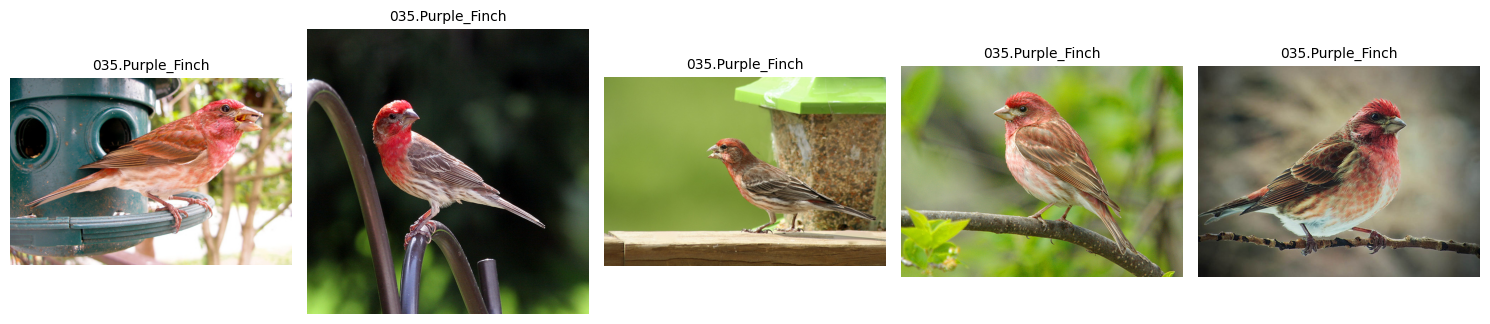

In [ ]:
# Choose random species folder and plot images
image_dir = dataset_path / "images"

image_paths = fetch_sample_images(image_dir, n=5)

plot_sample_images(image_paths)

In [ ]:
# Create official train-test split
# train-test split and core metadata are all in the main CUB_200_2011 folder
train_df, test_df = create_test_split(dataset_path)
train_df.head()

Loaded images.txt, image_class_labels.txt, classes.txt with 11788, 11788, and 200 entries respectively
Loaded split file 'train_test_split.txt' with 11788 entries
Merged metadata: 11788 rows, 5 columns -> ['image_id', 'image_path', 'class_id', 'class_name', 'is_training']
Total images: 11788
Train: 5994 | Test: 5794 | Train_Classes: 200| Test_Classes: 200


,image_id,image_path,class_id,class_name,is_training
0,2,001.Black_footed_Albatross/Black_Footed_Albatr...,1,001.Black_footed_Albatross,1
1,4,001.Black_footed_Albatross/Black_Footed_Albatr...,1,001.Black_footed_Albatross,1
2,5,001.Black_footed_Albatross/Black_Footed_Albatr...,1,001.Black_footed_Albatross,1
3,7,001.Black_footed_Albatross/Black_Footed_Albatr...,1,001.Black_footed_Albatross,1
4,8,001.Black_footed_Albatross/Black_Footed_Albatr...,1,001.Black_footed_Albatross,1


In [ ]:
# Create validation split
train_sub_df, val_sub_df = create_validation_split(train_df, val_fraction=0.2)

🔹 Training subset: 4795 images, 200 classes
🔹 Validation subset: 1199 images, 200 classes


In [ ]:
# Call check_no_overlap
check_no_overlap(train_sub_df, val_sub_df, test_df)

No overlapping image_ids between train, validation, and test sets.


In [ ]:
# Call plot class balance
plot_class_balance({
    "train": train_sub_df,
    "val": val_sub_df,
    "test": test_df
})

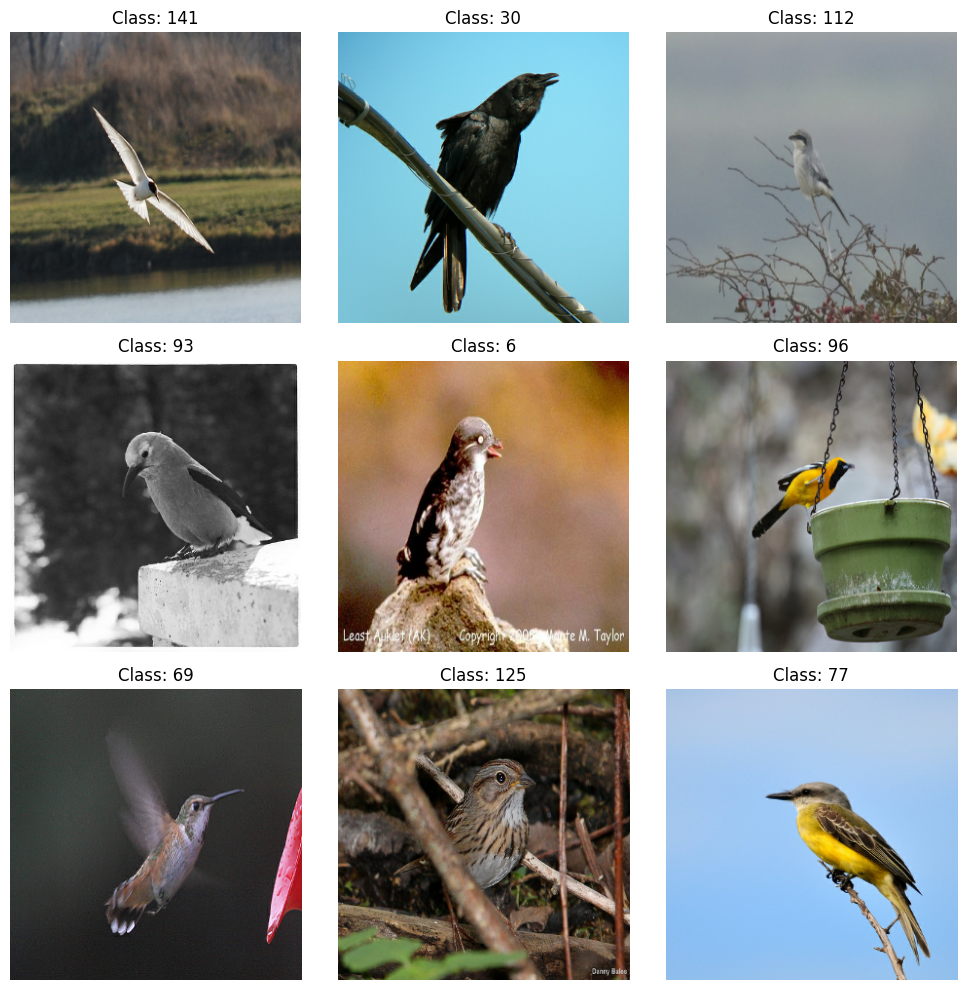

In [ ]:
# Call tf.Dataset creation and view images to check
image_size = (299, 299)

# Create tf.Datasets
exmpl_train_ds, exmpl_val_ds, exmpl_test_ds = create_tf_datasets(train_sub_df, val_sub_df, test_df, image_dir, image_size = image_size, batch_size = 32, inc_res_v2 = False, one_hot = False)

# Visualize one batch
show_batch(exmpl_train_ds, n=9)

In [ ]:
# Create tf.Dataset object for use in model (label is one hot encoded)
train_ds, val_ds, test_ds = create_tf_datasets(train_sub_df, val_sub_df, test_df, image_dir, image_size = image_size, batch_size = 32, inc_res_v2 = True, one_hot = True)

In [ ]:
# Apply spatial augmentations
seed_val = 42

# Define rotation and zoom parameters
rotation = 0.33 # set using evidence from EDA on Bounding Box Orientation angle (33 degrees means that the mean orientation of 41 can potentially be rotated to the max/min angles of 13/74)
zoom = [-0.64, 0] # set after Szegedy et al. 2015 - their cropping regime crops images to between 13% and 36% of input image size therefore 0.64 lower bound. They also keep the original images therefore 1 upper bound (no zooming out, only in).

# Define augmentation layers with flip, rotation, zoom (seeded)
aug_frz = tf.keras.Sequential([
    layers.RandomFlip("horizontal", seed = seed_val),
    layers.RandomRotation(factor = rotation, fill_mode = 'nearest', seed = seed_val),
    layers.RandomZoom(height_factor = zoom, fill_mode = 'nearest', seed = seed_val)
])

# Define augmentation layers with flip and rotation (seeded)
aug_fr = tf.keras.Sequential([
    layers.RandomFlip("horizontal", seed = seed_val),
    layers.RandomRotation(factor = rotation, fill_mode = 'nearest', seed = seed_val)
])

# Define augmentation layers with flip only (seeded)
aug_f = tf.keras.Sequential([
    layers.RandomFlip("horizontal", seed = seed_val),
])

In [ ]:
# Define model
num_classes = 200

# Define input
inputs = tf.keras.Input(shape=(image_size[0], image_size[1], 3))

# Apply augmentations (only active during training)
x = aug_frz(inputs)

# Load base model
base_model = InceptionResNetV2(weights="imagenet", include_top=False)
base_model.trainable = False  # freeze base layers

# Connect base model
x = base_model(x, training=False)  # ensures batch norm layers stay in inference mode

# Add pooling + prediction
x = layers.GlobalAveragePooling2D()(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)

# Create model
model = Model(inputs, outputs)

# Compile
model.compile(loss="categorical_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

In [ ]:
# Fit model
model.fit(train_ds, validation_data=val_ds, epochs=10)

Epoch 1/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 114s 521ms/step - accuracy: 0.0594 - loss: 5.0813 - val_accuracy: 0.1868 - val_loss: 3.3695
Epoch 2/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 80s 456ms/step - accuracy: 0.2501 - loss: 3.1839 - val_accuracy: 0.2811 - val_loss: 2.8090
Epoch 3/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 88s 507ms/step - accuracy: 0.3578 - loss: 2.6200 - val_accuracy: 0.3303 - val_loss: 2.5621
Epoch 4/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 81s 460ms/step - accuracy: 0.4361 - loss: 2.2636 - val_accuracy: 0.3586 - val_loss: 2.3798
Epoch 5/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 88s 508ms/step - accuracy: 0.4671 - loss: 2.1178 - val_accuracy: 0.3953 - val_loss: 2.2638
Epoch 6/10


In [ ]:
# Test model
#test_accuracy, test_loss = model.evaluate(test_ds)